Eileen Zhang 2020/08/12

**注 :yolov3.h5 文件 链接:https://pan.baidu.com/s/1-ybRNgCx8cvFXqn4myMe1A  密码:2dlq**

# Yolov3

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2 

In [12]:
model = tf.keras.models.load_model('../data/yolov3.h5') # yolov3.h5见网盘

如下两张图画的非常清楚了

![Yolov3](../data/yolov3.jpg)

![Yolov3](../data/yolov3_2.jpg)

In [13]:
model.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            [(None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, None, None, 5 11024384    yolo_darknet[1][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, None, None, 2 2957312     yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][1]          

# 模型预测

## 图片输入处理

In [38]:
def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

In [40]:
img_raw = tf.image.decode_image(
            open("../data/dog.jpg", 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, 416)

## 模型输出

**输出说明:** 255 =  (80(coco 数据集 80分类) + 5(x,y,w,h,confifence)) * 3(anchor)

In [65]:
%%time
out = model(img)

CPU times: user 3.7 s, sys: 2.53 s, total: 6.24 s
Wall time: 5.87 s


In [18]:
len(out)

3

In [64]:
out[0].shape,out[1].shape,out[2].shape

(TensorShape([1, 13, 13, 3, 85]),
 TensorShape([1, 26, 26, 3, 85]),
 TensorShape([1, 52, 52, 3, 85]))

anchors 设置

In [22]:
anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416
masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

In [23]:
classes = 80

In [8]:
anchors_0

array([[10., 13.],
       [16., 30.],
       [33., 23.]], dtype=float32)

Note: 把输出的anchor分开,out[0]对应的anchors_0三个anchor

## 得到 bbox, score

如论文下图需要把 $t_x t_y p_w p_h 转换成 b_x b_y b_w b_h$

![Yolov3_box](../data/yolov3_box.png)

In [28]:
def yolo_boxes(x, anchors, classes):
    import tensorflow as tf
    # x: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(x)[1:3]
    box_xy, box_wh, objectness, class_probs = tf.split(
        x, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # 构造grid 求 c_x c_y; !!! grid[y][x] == (x, y)
    grid = tf.meshgrid(tf.range(grid_size[1]), tf.range(grid_size[0]))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box

## nms

In [34]:
def yolo_nms(outputs, anchors, classes, yolo_max_boxes = 10 ,yolo_iou_threshold = 0.5, yolo_score_threshold = 0.5):
    import tensorflow as tf
    # boxes, confidence, class_probs
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class = yolo_max_boxes,
        max_total_size = yolo_max_boxes,
        iou_threshold = yolo_iou_threshold,
        score_threshold = yolo_score_threshold
    )

    return boxes, scores, classes, valid_detections

## Get bbox, score

In [51]:
class_names =  ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana","apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake","chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop",
    "mouse","remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator","book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [31]:
def detect(outputs, anchors = anchors,masks = masks, classes = 80, yolo_max_boxes = 10, yolo_iou_threshold = 0.5, yolo_score_threshold = 0.5):
    boxes_0 = yolo_boxes(outputs[0], anchors[masks[0]], classes)
    
    boxes_1 = yolo_boxes(outputs[1], anchors[masks[1]], classes)
    
    boxes_2 = yolo_boxes(outputs[2], anchors[masks[2]], classes)

    outputs = yolo_nms((boxes_0[:3], boxes_1[:3], boxes_2[:3]), anchors, classes, yolo_max_boxes, yolo_iou_threshold, yolo_score_threshold)
    
    return outputs

In [49]:
outputs = detect(out)

In [55]:
def draw_outputs(img, outputs, class_names):
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

In [56]:
out_img = draw_outputs(img, outputs, class_names)

In [58]:
cv2.imwrite('output.jpg', out_img)

True

In [59]:
from PIL import Image, ImageFont, ImageDraw

In [62]:
im01 =Image.open("output.jpg")

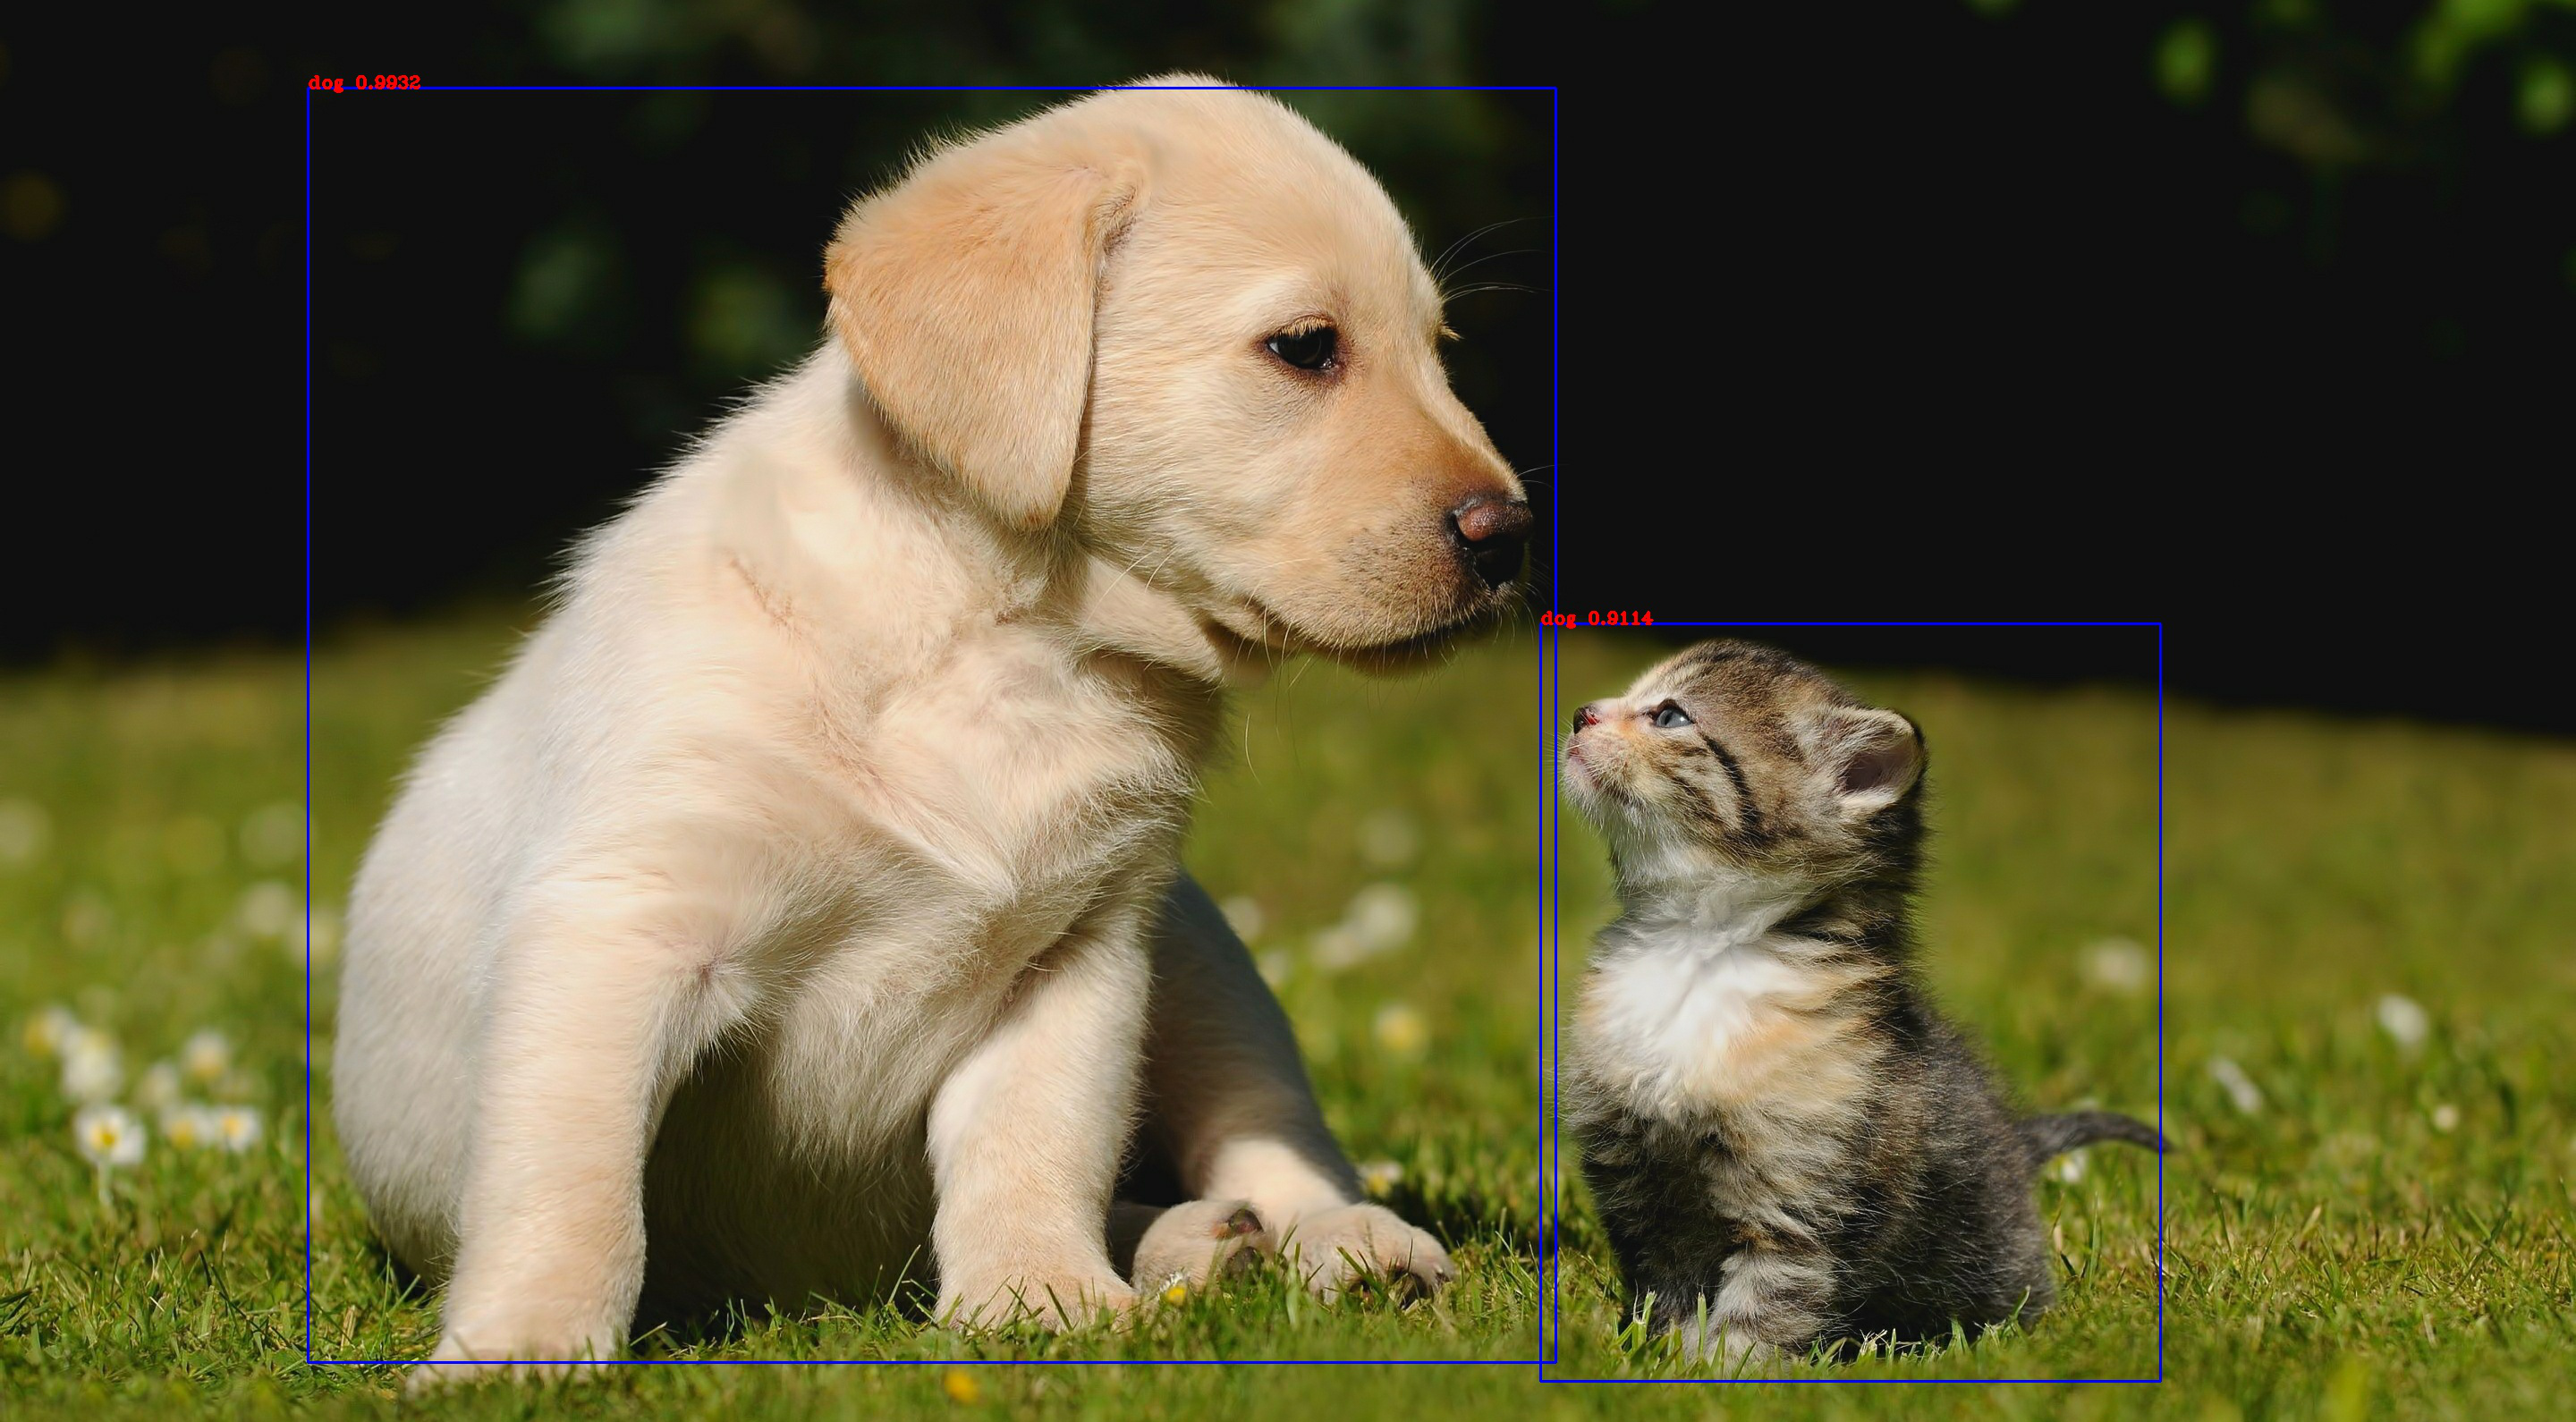

In [63]:
im01